# GOAL: notifications + divergence notifications
------------------------------------------------------------------------------
- Bollinger Band............. yes
- RSI........................ no
- RSI Divergence............. yes
- MACD....................... no
- VWAP....................... yes
- RVI........................ yes
- MFI........................ yes
- Min & Max lines............ yes
- Moving Averages............ yes
- Candlestick Patterns....... no
- Risk Analysis.............. yes
- Earnings & Financials...... yes
- News....................... yes
- Put/Call Ratio............. no
- Trending................... yes
- Consolodating.............. no
- Buy Score:   Some #/#

In [1]:
#importing variables
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import matplotlib.dates as mpl_dates
import seaborn as sns
import matplotlib.pyplot as plt
import math
from openpyxl import load_workbook
# Find local peaks
from scipy.signal import argrelextrema
import yfinance as yf
import talib, datetime

In [2]:
# Function to get Bollinger Bands
def getBBands(df, period=10, stdNbr=2):
        try:
            close = df['Close']
        except Exception as ex:
            return None

        try:
            upper, middle, lower = talib.BBANDS(
                                close.values, 
                                timeperiod=period,
                                # number of non-biased standard deviations from the mean
                                nbdevup=stdNbr,
                                nbdevdn=stdNbr,
                                # Moving average type: simple moving average here
                                matype=0)
        except Exception as ex:
            return None

        data = dict(upper=upper, middle=middle, lower=lower, close=close)
        df = pd.DataFrame(data, index=df.index, columns=['upper', 'middle', 'lower','close']).dropna()

        return df 


In [ ]:
# Smoothing with Wilder puts emphasis on recent values
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [3]:
# Import data for the year of ticker(s)
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []
tickers_final = ['spy']

for i in tickers_final:
    try:
        test_data = yf.download(tickers=i, period = '1y', interval = '1d')
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
    except Exception as e:
        no_data.append(i)
        print(e)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Makes RSI column and initializes RSI parameter variables
all_data['RSI'] = talib.RSI(all_data['Adj Close'], timeperiod=20)
lower_barrier = 30
upper_barrier = 70
width = 10

# Sets up different dataset for finding RSI divergence
Data = all_data.copy()
Data.drop(['Adj Close','Volume', 'symbol'], axis=1, inplace=True)
Data.head(2)

,Open,High,Low,Close,RSI
Date,,,,,
2020-07-09,316.839996,317.100006,310.679993,314.380005,NaN
2020-07-10,314.309998,317.880005,312.760010,317.589996,NaN
2020-07-13,320.130005,322.709991,314.130005,314.839996,NaN
2020-07-14,313.299988,319.760010,312.000000,318.920013,NaN
2020-07-15,322.410004,323.040009,319.269989,321.850006,NaN
2020-07-16,319.790009,321.279999,319.089996,320.790009,NaN
2020-07-17,321.880005,322.570007,319.739990,321.720001,NaN
2020-07-20,321.429993,325.130005,320.619995,324.320007,NaN
2020-07-21,326.450012,326.929993,323.940002,325.010010,NaN


In [5]:
Data['Bullish Divergence'] = ""
Data['Bearish Divergence'] = ""

# Bullish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] < lower_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] > lower_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] < lower_barrier and Data.iloc[r, 4] > Data.iloc[i, 4] and Data.iloc[r, 3] < Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] > lower_barrier:
                                    print('Bullish above',Data.iloc[s+1,2])
                                    Data.iloc[s + 1, 5] = 1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError:
        pass
    
#Bearish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] > upper_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] < upper_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] > upper_barrier and Data.iloc[r, 4] < Data.iloc[i, 4] and Data.iloc[r, 3] > Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] < upper_barrier:
                                    print('Bearish below',Data.iloc[s+1,2])
                                    Data.iloc[s + 1, 6] = -1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError:
        pass

Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 335.2200012207031
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875
Bearish below 334.8699951171875


In [7]:
# # Creates Return column
# all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 
# all_data.head(5)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,return
Date,,,,,,,,,
2020-07-09,316.839996,317.100006,310.679993,314.380005,309.766174,83354200,spy,NaN,NaN
2020-07-10,314.309998,317.880005,312.760010,317.589996,312.929077,57550400,spy,NaN,0.010211
2020-07-13,320.130005,322.709991,314.130005,314.839996,310.219391,102997500,spy,NaN,-0.008659
2020-07-14,313.299988,319.760010,312.000000,318.920013,314.239563,93657000,spy,NaN,0.012959
2020-07-15,322.410004,323.040009,319.269989,321.850006,317.126526,87196500,spy,NaN,0.009187


In [8]:
# Fixes index problem
all_data = all_data[~all_data.index.duplicated()]

# Columns dropped for testing
# all_data.drop(index=all_data.index[:-65], axis=0, inplace=True)
# all_data.drop(index=all_data.index[-20:], axis=0, inplace=True)
all_data.tail(4)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,return
Date,,,,,,,,,
2021-07-02,431.670013,434.100006,430.519989,433.720001,433.720001,57679000,spy,67.873663,0.007644
2021-07-06,433.779999,434.010010,430.010010,432.929993,432.929993,68710400,spy,66.471182,-0.001821
2021-07-07,433.660004,434.760010,431.510010,434.459991,434.459991,63458800,spy,67.826465,0.003534
2021-07-08,428.779999,431.730011,427.519989,430.920013,430.920013,96997650,spy,61.747660,-0.008148


In [9]:
# Tries with sensitivity level 4
n = 7
all_data['min'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']


In [10]:
# Tries with sensitivity level 20
n = 12
all_data['min1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']

In [11]:
# Extra sensitivity level (optional)
n = 25
all_data['min4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']
all_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,return,min,max,min1,max1,min4,max4
Date,,,,,,,,,,,,,,,
2021-07-01,428.869995,430.600006,428.799988,430.429993,430.429993,53441000,spy,64.947699,0.005537,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-02,431.670013,434.100006,430.519989,433.720001,433.720001,57679000,spy,67.873663,0.007644,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-06,433.779999,434.010010,430.010010,432.929993,432.929993,68710400,spy,66.471182,-0.001821,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-07,433.660004,434.760010,431.510010,434.459991,434.459991,63458800,spy,67.826465,0.003534,NaN,434.459991,NaN,434.459991,NaN,434.459991
2021-07-08,428.779999,431.730011,427.519989,430.920013,430.920013,96997650,spy,61.747660,-0.008148,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Draws lines for the mins and maxes - first performs shift operations
all_data['prev_min'] = all_data['min'].shift(1)
all_data['min'] = all_data.apply(lambda x : 0  if ((x['min'] == x['prev_min'])) else x['min'], axis=1)
all_data['prev_max'] = all_data['max'].shift(1)
all_data['max'] = all_data.apply(lambda x : 0  if ((x['max'] == x['prev_max'])) else x['max'], axis=1)

all_data['prev_min1'] = all_data['min1'].shift(1)
all_data['min1'] = all_data.apply(lambda x : 0  if ((x['min1'] == x['prev_min1'])) else x['min1'], axis=1)
all_data['prev_max1'] = all_data['max1'].shift(1)
all_data['max1'] = all_data.apply(lambda x : 0  if ((x['max1'] == x['prev_max1'])) else x['max1'], axis=1)

all_data['prev_min2'] = all_data['min4'].shift(1)
all_data['min4'] = all_data.apply(lambda x : 0  if ((x['min4'] == x['prev_min2'])) else x['min4'], axis=1)
all_data['prev_max2'] = all_data['max4'].shift(1)
all_data['max4'] = all_data.apply(lambda x : 0  if ((x['max4'] == x['prev_max2'])) else x['max4'], axis=1)

# n = smaller number
all_data['min2'] = all_data['min'].replace({0:np.nan})
all_data.min2 = all_data['min2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max2'] = all_data['max'].replace({0:np.nan})
all_data.max2 = all_data['max2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
# n = larger number
all_data['min3'] = all_data['min1'].replace({0:np.nan})
all_data.min3 = all_data['min3'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max3'] = all_data['max1'].replace({0:np.nan})
all_data.max3 = all_data['max3'].interpolate(method='spline', limit_direction='forward',order = 1, axis=0)
# n = (optional other)
all_data['min5'] = all_data['min4'].replace({0:np.nan})
all_data.min5 = all_data['min5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max5'] = all_data['max4'].replace({0:np.nan})
all_data.max5 = all_data['max5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)

In [13]:
# all_data['RSI_DIV'] = all_data['RSI'] / all_data['min3'] 
# all_data['RSI_DIV1'] = all_data['RSI'] / all_data['max3'] 
# all_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,return,min,...,prev_min2,prev_max2,min2,max2,min3,max3,min5,max5,RSI_DIV,RSI_DIV1
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-22,415.890015,416.779999,411.130005,412.269989,410.925629,97582800,spy,61.723709,-0.009133,NaN,...,NaN,NaN,397.238439,414.377420,396.980399,416.365460,396.863425,415.519217,0.155483,0.148244
2021-04-23,412.869995,418.250000,412.790009,416.739990,415.381042,73209200,spy,64.873625,0.010842,NaN,...,NaN,NaN,397.565594,414.828098,397.367238,416.710947,397.259607,415.768438,0.163259,0.155680
2021-04-26,417.440002,418.220001,416.809998,417.609985,416.248199,52182400,spy,65.456033,0.002088,NaN,...,NaN,NaN,398.547061,416.180131,398.527755,417.747407,398.448153,416.516100,0.164245,0.156688
2021-04-27,417.929993,418.140015,416.299988,417.519989,416.158508,51303100,spy,65.338086,-0.000216,NaN,...,NaN,NaN,398.874217,416.630808,398.914594,418.092894,398.844335,416.765321,0.163790,0.156276
2021-04-28,417.809998,419.010010,416.899994,417.399994,416.038879,51238900,spy,65.173205,-0.000287,NaN,...,NaN,NaN,399.201372,417.081486,399.301433,418.438381,399.240517,417.014542,0.163218,0.155753
2021-04-29,420.320007,420.720001,416.440002,420.059998,418.690216,78544300,spy,67.109537,0.006373,NaN,...,NaN,NaN,399.528528,417.532163,399.688272,418.783868,399.636700,417.263762,0.167905,0.160249
2021-04-30,417.630005,418.540009,416.339996,417.299988,415.939209,85527000,spy,63.267594,-0.006571,NaN,...,NaN,NaN,399.855683,417.982841,400.075111,419.129355,400.032882,417.512983,0.158139,0.150950
2021-05-03,419.429993,419.839996,417.670013,418.200012,416.836304,68128300,spy,63.975519,0.002157,NaN,...,NaN,NaN,400.837150,419.334874,401.235628,420.165815,401.221428,418.260645,0.159446,0.152263
2021-05-04,416.070007,416.600006,411.670013,415.619995,414.264709,101591200,spy,60.459562,-0.006169,NaN,...,NaN,NaN,401.164305,419.785551,401.622467,420.511302,401.617610,418.509866,0.150538,0.143776


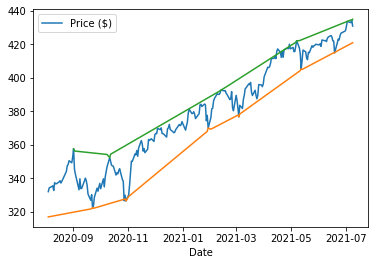

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min3)
plt.plot(all_data.max3)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

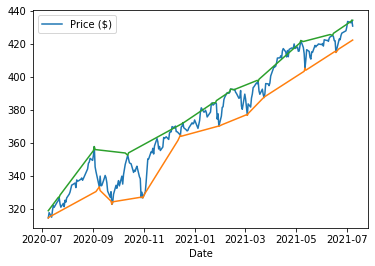

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min2)
plt.plot(all_data.max2)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

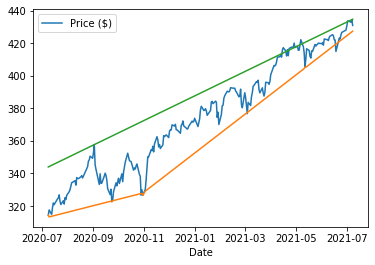

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min5)
plt.plot(all_data.max5)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

In [17]:
# Bollinger Band function used
all_data = all_data.merge(getBBands(all_data,period=20,stdNbr=2), on = 'Date')

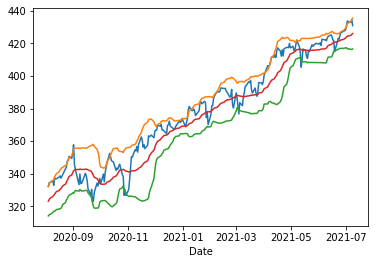

In [18]:
# Big picture
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
plt.plot(all_data.upper)
plt.plot(all_data.lower)
plt.plot(all_data.middle)
plt.xlabel('Date')

# plt.legend(['Price ($)','Max5','Min5','Max3','Min3','Max2','Min2'], loc = 'upper left')
plt.show()

In [19]:
# We want notifications for all these plus divergence notifications:
# Buy/Sell when crosses middle band
# Bollinger Band............. yes
# RSI........................ no
# RSI Divergence............. yes
# MACD....................... no
# VWAP....................... yes
# RVI........................ yes
# MFI........................ yes
# Min & Max lines............ yes
# Moving Averages............ yes
# Candlestick Patterns....... no
# Risk Analysis.............. yes
# Earnings & Financials...... yes
# News....................... yes
# Put/Call Ratio............. no
# Trending................... yes
# Consolodating.............. no
# Buy Score: 

In [ ]:
# MACD Calculations: check if it is higher than the signal (bullish)
all_data['ShortEMA'] = all_data.Close.transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['LongEMA'] = all_data.Close.transform(lambda x: x.ewm(span=35, adjust=False).mean())
all_data['MACD'] = all_data.ShortEMA - all_data.LongEMA
all_data['signal'] = all_data.MACD.transform(lambda x: x.ewm(span=3, adjust=False).mean())
all_data['macd_bullish'] = all_data.apply(lambda x : 1 if (x['MACD'] - x['signal'] > 0) else 0, axis = 1)

In [ ]:
# Shifts in MACD and RVI are used to determine signal direction
# All the necessary calculations for the RVI, including the RVI Signal (lot of shifting to get past data)
df = all_data.copy()
df['open_shift'] = df.Open.shift(1)
df['open_shift2'] = df.Open.shift(2)
df['open_shift3'] = df.Open.shift(3)
df['low_shift'] = df.Low.shift(1)
df['low_shift2'] = df.Low.shift(2)
df['low_shift3'] = df.Low.shift(3)

df['numerator'] = ((1 * (df.Close - df.Open)) + (2 * (df.Close - df.open_shift)) + (2 * (df.Close - df.open_shift2)) + 
                   (1 * (df.Close - df.open_shift3))) / 6
df['denominator'] = (1 * (df.High - df.Low) + (2 * (df.High - df.low_shift)) + (2 * (df.High - df.low_shift2)) + 
                   (1 * (df.High - df.low_shift3))) / 6

df['SMA_numerator'] = df['numerator'].transform(lambda x: x.rolling(window = 10).mean())
df['SMA_denominator'] = df['denominator'].transform(lambda x: x.rolling(window = 10).mean())   
df['RVI'] = df['SMA_numerator'] / df['SMA_denominator']          
df['rvishift'] = df.RVI.shift(1)
df['rvishift2'] = df.RVI.shift(2)
df['rvishift3'] = df.RVI.shift(3)

df['RVI_Signal'] = ((1* df.RVI) + (2 * df.rvishift) + (2 * df.rvishift2) + (1*df.rvishift3)) / 6
df['rvi_bullish'] = df.apply(lambda x : 1 if (x['RVI'] - x['RVI_Signal'] > 0) else 0, axis = 1)
all_data = df.copy()

In [20]:
# ATR and ADX are used to determine signal strength
# ATR ratio and ADX is used to figure out a true range, for volatility
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                    np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                    abs(all_data['prev_close'] - all_data['Low'])))

for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)
all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

# Took this code from the internet for ATR AND ADX for a different project, along with the Wilder smoothing stuff
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                        np.where((all_data['High'] > all_data['prev_high']) & 
        (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                all_data['High'] - all_data['prev_high'], 
                                                                0),np.nan)
all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                        np.where((all_data['prev_low'] > all_data['Low']) & 
        (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100
all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

# Determine if the stock has momentum and volatility (strength of the signal)
all_data['adx_signal'] = all_data.apply(lambda x : 1 if (x['ADX_15'] >= 25) else 0, axis = 1)
all_data['atr_signal'] = all_data.apply(lambda x : 1 if (x['ATR_Ratio'] >= 1) else 0, axis = 1)


,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,return,min,...,min3,max3,min5,max5,RSI_DIV,RSI_DIV1,upper,middle,lower,close
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-28,417.809998,419.010010,416.899994,417.399994,416.038879,51238900,spy,65.173205,-0.000287,NaN,...,399.301433,418.438381,399.240517,417.014542,0.163218,0.155753,423.017539,411.504495,399.991452,417.399994
2021-04-29,420.320007,420.720001,416.440002,420.059998,418.690216,78544300,spy,67.109537,0.006373,NaN,...,399.688272,418.783868,399.636700,417.263762,0.167905,0.160249,422.463673,412.690996,402.918318,420.059998
2021-04-30,417.630005,418.540009,416.339996,417.299988,415.939209,85527000,spy,63.267594,-0.006571,NaN,...,400.075111,419.129355,400.032882,417.512983,0.158139,0.150950,421.758239,413.525496,405.292753,417.299988
2021-05-03,419.429993,419.839996,417.670013,418.200012,416.836304,68128300,spy,63.975519,0.002157,NaN,...,401.235628,420.165815,401.221428,418.260645,0.159446,0.152263,421.894226,414.117497,406.340769,418.200012
2021-05-04,416.070007,416.600006,411.670013,415.619995,414.264709,101591200,spy,60.459562,-0.006169,NaN,...,401.622467,420.511302,401.617610,418.509866,0.150538,0.143776,421.465233,414.592497,407.719761,415.619995
2021-05-05,417.380005,417.630005,415.149994,415.750000,414.394287,60162200,spy,60.574486,0.000313,NaN,...,402.009306,420.856789,402.013792,418.759087,0.150679,0.143931,420.869037,415.050497,409.231958,415.750000
2021-05-06,415.829987,419.209991,413.679993,419.070007,417.703461,74321400,spy,63.431685,0.007986,NaN,...,402.396145,421.202276,402.409974,419.008307,0.157635,0.150597,420.816716,415.577998,410.339281,419.070007
2021-05-07,419.890015,422.820007,419.160004,422.119995,420.743500,67733800,spy,65.826586,0.007278,NaN,...,402.782984,422.119995,402.806156,419.257528,0.163429,0.155943,421.724779,416.109499,410.494219,422.119995
2021-05-10,422.500000,422.739990,417.809998,417.940002,416.577148,81852400,spy,60.144216,-0.009902,NaN,...,403.943502,422.197498,403.994702,420.005190,0.148893,0.142455,421.697956,416.424498,411.151040,417.940002
